In [12]:
!pip install timm tqdm torchvision torchmetrics


In [13]:
import os
import torch
import numpy as np
import timm
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from torchmetrics import Accuracy, Precision, Recall, F1Score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [32]:

# Directories
train_dir = "/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train"
val_dir = "/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold5/Valid"
test_dir = "/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold5/Test"

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet normalization
])

# Load datasets
train_data = ImageFolder(root=train_dir, transform=transform)
val_data = ImageFolder(root=val_dir, transform=transform)
test_data = ImageFolder(root=test_dir, transform=transform)


In [33]:

# Class weights for imbalanced dataset
class_counts = np.bincount(train_data.targets)
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
sample_weights = [class_weights[label] for label in train_data.targets]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
BATCH_SIZE = 16
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_data)} | Val samples: {len(val_data)} | Test samples: {len(test_data)}")


Train samples: 7532 | Val samples: 154 | Test samples: 63


In [34]:

# ViT Model Class
class ViTClassifier(nn.Module):
    def __init__(self, num_classes=6):
        super(ViTClassifier, self).__init__()
        self.backbone = timm.create_model("vit_base_patch16_224", pretrained=True)
        self.backbone.head = nn.Linear(self.backbone.head.in_features, num_classes)  # Replace classification head
        
    def forward(self, x):
        return self.backbone(x)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTClassifier(num_classes=6).to(device)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [35]:
# Freeze all layers
for param in model.backbone.parameters():
    param.requires_grad = False

# Unfreeze only the last 10 layers
for param in list(model.backbone.parameters())[-10:]:
    param.requires_grad = True


In [41]:

# Loss function (Weighted Cross-Entropy)
class_weights = torch.tensor(class_counts.max() / class_counts, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3, verbose=True)

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    best_val_acc = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Progress bar
        loop = tqdm(train_loader, leave=True)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=running_loss / len(train_loader), acc=correct / total)
        
        val_acc = evaluate(model, val_loader)
        scheduler.step(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_vit_model_epoch20_ft10.pth")

    print("Training complete. Best validation accuracy: {:.2f}%".format(best_val_acc * 100))

# Evaluation Function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Train ViT Model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10)


Epoch [10/10]: 100%|██████████| 471/471 [01:37<00:00,  4.84it/s, acc=0.997, loss=0.00576]


Training complete. Best validation accuracy: 82.47%


Finetuning_epoch5

<ipython-input-37-46a7a274c478>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vit_model.pth"))


Accuracy: 87.30%
Precision: 0.862
Recall: 0.863
F1 Score: 0.862


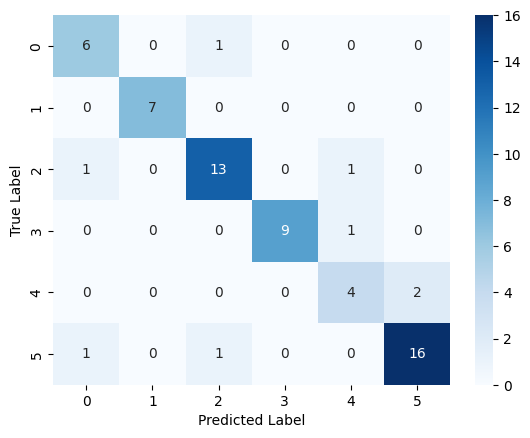

              precision    recall  f1-score   support

  Chickenpox       0.75      0.86      0.80         7
      Cowpox       1.00      1.00      1.00         7
        HFMD       0.87      0.87      0.87        15
     Healthy       1.00      0.90      0.95        10
     Measles       0.67      0.67      0.67         6
   Monkeypox       0.89      0.89      0.89        18

    accuracy                           0.87        63
   macro avg       0.86      0.86      0.86        63
weighted avg       0.88      0.87      0.87        63



In [37]:

# Test Function
def test_model(model, test_loader):
    model.load_state_dict(torch.load("best_vit_model.pth"))
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

# Evaluate on Test Set
true_labels, pred_labels = test_model(model, test_loader)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy: {:.2f}%".format(accuracy_score(true_labels, pred_labels) * 100))
print("Precision: {:.3f}".format(precision_score(true_labels, pred_labels, average='macro')))
print("Recall: {:.3f}".format(recall_score(true_labels, pred_labels, average='macro')))
print("F1 Score: {:.3f}".format(f1_score(true_labels, pred_labels, average='macro')))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
print(classification_report(true_labels, pred_labels, target_names=train_data.classes))


Finetuning_epoch10

<ipython-input-40-bcdf4b4492d4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vit_model_epoch10_ft10.pth"))


Accuracy: 88.89%
Precision: 0.914
Recall: 0.849
F1 Score: 0.866


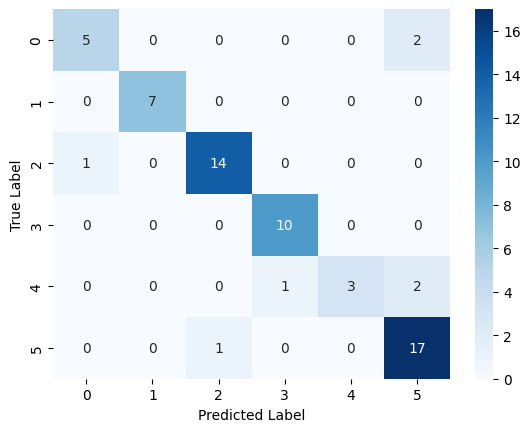

              precision    recall  f1-score   support

  Chickenpox       0.83      0.71      0.77         7
      Cowpox       1.00      1.00      1.00         7
        HFMD       0.93      0.93      0.93        15
     Healthy       0.91      1.00      0.95        10
     Measles       1.00      0.50      0.67         6
   Monkeypox       0.81      0.94      0.87        18

    accuracy                           0.89        63
   macro avg       0.91      0.85      0.87        63
weighted avg       0.90      0.89      0.88        63



In [40]:

# Test Function
def test_model(model, test_loader):
    model.load_state_dict(torch.load("best_vit_model_epoch10_ft10.pth"))
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

# Evaluate on Test Set
true_labels, pred_labels = test_model(model, test_loader)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy: {:.2f}%".format(accuracy_score(true_labels, pred_labels) * 100))
print("Precision: {:.3f}".format(precision_score(true_labels, pred_labels, average='macro')))
print("Recall: {:.3f}".format(recall_score(true_labels, pred_labels, average='macro')))
print("F1 Score: {:.3f}".format(f1_score(true_labels, pred_labels, average='macro')))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
print(classification_report(true_labels, pred_labels, target_names=train_data.classes))


<ipython-input-42-6649d9acf533>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vit_model_epoch20_ft10.pth"))


Accuracy: 85.71%
Precision: 0.902
Recall: 0.801
F1 Score: 0.831


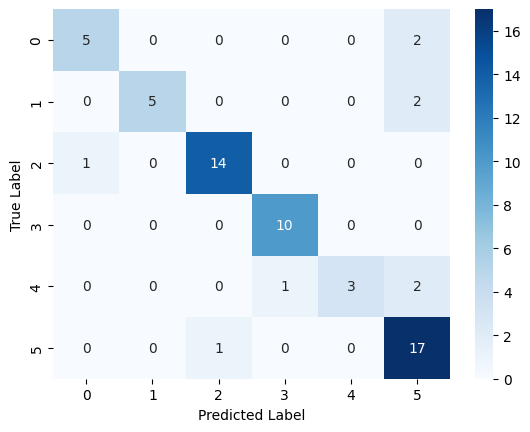

              precision    recall  f1-score   support

  Chickenpox       0.83      0.71      0.77         7
      Cowpox       1.00      0.71      0.83         7
        HFMD       0.93      0.93      0.93        15
     Healthy       0.91      1.00      0.95        10
     Measles       1.00      0.50      0.67         6
   Monkeypox       0.74      0.94      0.83        18

    accuracy                           0.86        63
   macro avg       0.90      0.80      0.83        63
weighted avg       0.88      0.86      0.85        63



In [42]:

# Test Function
def test_model(model, test_loader):
    model.load_state_dict(torch.load("best_vit_model_epoch20_ft10.pth"))
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

# Evaluate on Test Set
true_labels, pred_labels = test_model(model, test_loader)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy: {:.2f}%".format(accuracy_score(true_labels, pred_labels) * 100))
print("Precision: {:.3f}".format(precision_score(true_labels, pred_labels, average='macro')))
print("Recall: {:.3f}".format(recall_score(true_labels, pred_labels, average='macro')))
print("F1 Score: {:.3f}".format(f1_score(true_labels, pred_labels, average='macro')))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
print(classification_report(true_labels, pred_labels, target_names=train_data.classes))
